In [35]:
import os
import itk
import vtk
from vtk import vtkCommand
import numpy as np
import matplotlib.pyplot as plt

In [36]:
NII_PATH = "/Users/benjaminhon/Developer/HeadHunter/notebooks/213046.nii"

# Read NII

In [54]:
inputImageType = itk.Image[itk.UC, 3]
reader = itk.ImageFileReader[inputImageType].New()
reader.SetFileName(NII_PATH)
reader.Update()
image = reader.GetOutput()

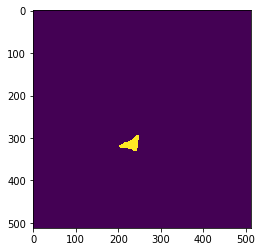

In [55]:
%matplotlib inline
arr = itk.GetArrayViewFromImage(data)
plt.imshow(arr[4])

In [57]:
print(image.GetOrigin())
print(image.GetSpacing())
print(image.GetDirection())

itkPointD3 ([0, 0, 0])
itkVectorD3 ([0.00046875, 0.000468756, 0.00600015])
<itkMatrixPython.itkMatrixD33; proxy of <Swig Object of type 'itkMatrixD33 *' at 0x12ba58330> >


# Segmentation